In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=b7eda9f6114191e0417cf94c19ac7cebb5b808af71819f42924824620a0ead32
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
import pandas as pd
import numpy as np
import sklearn
import gc
import keras
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import GRU, GlobalMaxPool1D, dot, LSTM, Dense, Dropout, TimeDistributed, Conv1D, Conv2D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import MinMaxScaler
from keras_self_attention import SeqSelfAttention

**LOAD DATA**


In [ ]:
Header=[]
for i in range (1,138) :
  Header.append('Pv'+ str(i))

df = pd.read_csv('/content/drive/MyDrive/dataset/solar_AL.csv', names=Header)

when = pd.date_range(start=pd.datetime(2006,1,1),freq='10min',periods=len(df))
df["Datetime"]=when
df=df.set_index('Datetime',inplace=False)

df.head()

print(df.shape)

(52560, 137)


<ipython-input-4-06d5bd15ceac>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  when = pd.date_range(start=pd.datetime(2006,1,1),freq='10min',periods=len(df))


**Data Visualization**

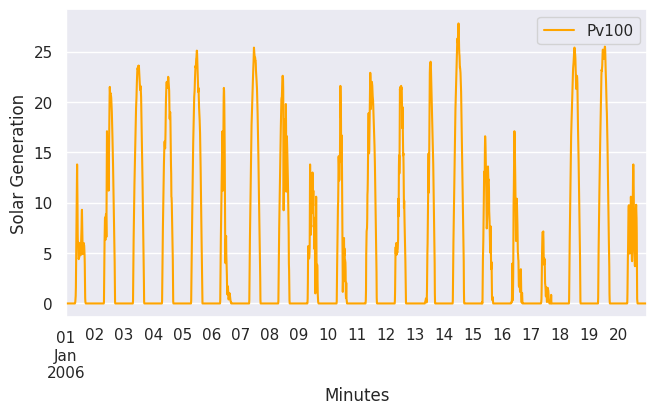

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})

df.iloc[0:2880].plot(y=['Pv100'] ,color=['orange'])

plt.ylabel('Solar Generation')
plt.xlabel('Minutes')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

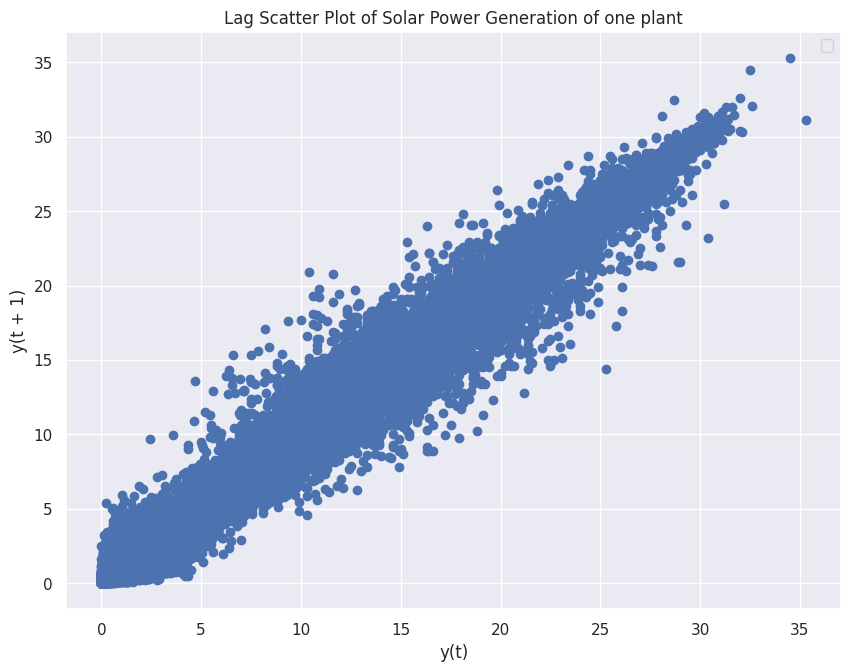

In [ ]:
from pandas.plotting import lag_plot
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,7.5)})
# lag scatter plot
lag_plot(df['Pv22'])
plt.title('Lag Scatter Plot of Solar Power Generation of one plant')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

[Text(0.5, 0, 'Months'),
 Text(0, 0.5, 'Solar Power Generation'),
 Text(0.5, 1.0, 'Boxplots over each month of year the 2006 of a plant')]

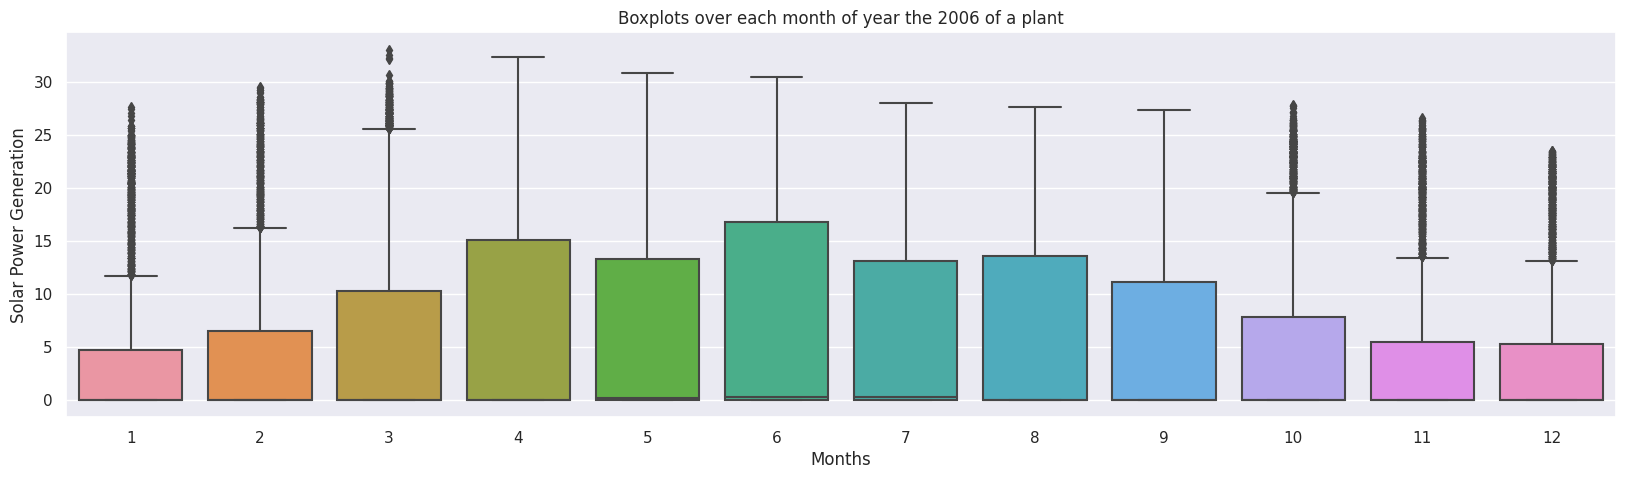

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
gfg = sns.boxplot(x = df.index.month,
                y = df['Pv10'],
                ax = ax)
gfg.set(xlabel ="Months", ylabel = "Solar Power Generation", title ='Boxplots over each month of year the 2006 of a plant')

**MINMAX SCALING**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dff = df
scalers={}
for i in df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(dff[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    dff[i]=s_s

In [ ]:
n_past = 24
n_future = 3
n_features = 137

In [ ]:
def split_series(series, n_past, n_future):

  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

**ADDITIVE DECOMPOSITION to COLLECT RESIDUALS**

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

# Generate example time series data


# Decompose the time series into its trend, seasonal, and residual components using additive decomposition
residual = {}
seasonal ={}
trend= {}
d=0
for ts in df.columns:
    decomposition = sm.tsa.seasonal_decompose(dff[ts], period = 60*24, model='additive')
    residual[ts] = decomposition.resid.copy()


residual=pd.DataFrame(residual)
residual.columns=Header
residual=residual.fillna(0)

del(decomposition)
gc.collect()

17

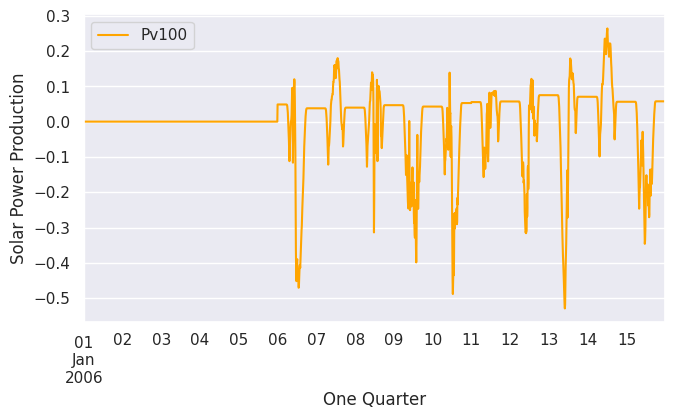

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})
residual.iloc[0:2160].plot(y=['Pv100'] ,color=['orange'])

plt.ylabel('Solar Power Production')
plt.xlabel('One Quarter')

plt.show()

In [ ]:
train_residual,test_residual = residual[0:7884], residual[7884:]
train_residual, valid_residual = residual[0:7095], residual[7095:7884]

In [ ]:
X_trainr, y_trainr = split_series(train_residual.values,n_past, n_future)
X_trainr = X_trainr.reshape((X_trainr.shape[0], X_trainr.shape[1],n_features))
y_trainr = y_trainr.reshape((y_trainr.shape[0], y_trainr.shape[1], n_features))
X_testr, y_testr = split_series(test_residual.values,n_past, n_future)
X_testr = X_testr.reshape((X_testr.shape[0], X_testr.shape[1],n_features))
y_testr = y_testr.reshape((y_testr.shape[0], y_testr.shape[1], n_features))
X_validr, y_validr = split_series(valid_residual.values,n_past, n_future)
X_validr = X_validr.reshape((X_validr.shape[0], X_validr.shape[1],n_features))
y_validr = y_validr.reshape((y_validr.shape[0], y_validr.shape[1], n_features))

##Stacked GRU


In [ ]:
modelr = Sequential()
modelr.add(GRU(units=128,
                                 return_sequences=True,
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 ))
modelr.add(Dropout(0.2))
modelr.add(GRU(units=128,
                                 return_sequences=False,
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 ))
modelr.add(RepeatVector(n_future))
modelr.add(TimeDistributed(Dense(units=n_features, activation = 'tanh')))
modelr.compile(loss='mae', optimizer='adam')
modelr.build((None, n_past, n_features))
modelr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 24, 128)           102528    
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 24, 128)           0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 128)               99072     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 3, 128)            0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 3, 137)            17673     
Total params: 219,273
Trainable params: 219,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history=modelr.fit(X_trainr,y_trainr,epochs=20,validation_data=(X_validr,y_validr),batch_size=16,verbose=1,callbacks=[reduce_lr,es])

Epoch 1/20
442/442 [==============================] - 54s 82ms/step - loss: 0.0300 - val_loss: 0.0359
Epoch 2/20
442/442 [==============================] - 28s 62ms/step - loss: 0.0240 - val_loss: 0.0338
Epoch 3/20
442/442 [==============================] - 29s 66ms/step - loss: 0.0232 - val_loss: 0.0327
Epoch 4/20
442/442 [==============================] - 19s 43ms/step - loss: 0.0222 - val_loss: 0.0317
Epoch 5/20
442/442 [==============================] - 21s 48ms/step - loss: 0.0216 - val_loss: 0.0319
Epoch 6/20
442/442 [==============================] - 19s 44ms/step - loss: 0.0211 - val_loss: 0.0317
Epoch 7/20
442/442 [==============================] - 19s 44ms/step - loss: 0.0207 - val_loss: 0.0320
Epoch 8/20
442/442 [==============================] - 22s 51ms/step - loss: 0.0204 - val_loss: 0.0315
Epoch 9/20
442/442 [==============================] - 20s 46ms/step - loss: 0.0200 - val_loss: 0.0321
Epoch 10/20
442/442 [==============================] - 21s 48ms/step - loss: 0.019

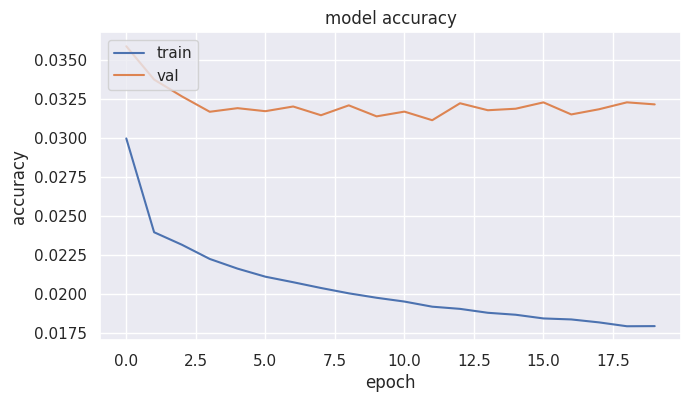

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
modelr.evaluate(X_testr,y_testr)

1396/1396 [==============================] - 29s 21ms/step - loss: 0.0288


0.028804512694478035

In [ ]:
predr = modelr.predict(X_testr)

In [ ]:
del(modelr)
del(X_testr)
del(X_trainr)
del(X_validr)
del(y_testr)
del(y_trainr)
del(y_validr)
del(residual)
gc.collect()

13407

**ADDITIVE DECOMPOSTION to COLLECT TREND**


In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

# Generate example time series data


# Decompose the time series into its trend, seasonal, and residual components using additive decomposition
trend= {}
for ts in df.columns:
    decomposition = sm.tsa.seasonal_decompose(dff[ts], period = 60*24, model='additive')
    trend[ts] = decomposition.trend.copy()

trend=pd.DataFrame(trend)
trend.columns=Header
trend=trend.fillna(0)

del(decomposition)
gc.collect()

0

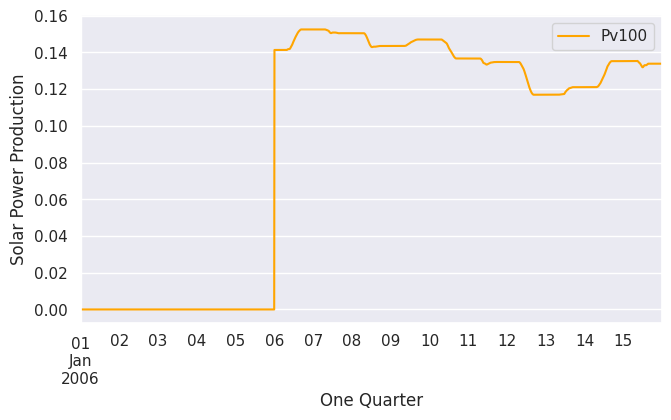

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})
trend.iloc[0:2160].plot(y=['Pv100'] ,color=['orange'])

plt.ylabel('Solar Power Production')
plt.xlabel('One Quarter')

plt.show()

In [ ]:
# Split the data into train and test sets
train_trend,test_trend = trend[0:7884], trend[7884:]
train_trend, valid_trend = trend[0:7095], trend[7095:7884]

In [ ]:
X_traint, y_traint = split_series(train_trend.values,n_past, n_future)
X_traint = X_traint.reshape((X_traint.shape[0], X_traint.shape[1],n_features))
y_traint = y_traint.reshape((y_traint.shape[0], y_traint.shape[1], n_features))
X_testt, y_testt = split_series(test_trend.values,n_past, n_future)
X_testt = X_testt.reshape((X_testt.shape[0], X_testt.shape[1],n_features))
y_testt = y_testt.reshape((y_testt.shape[0], y_testt.shape[1], n_features))
X_validt, y_validt = split_series(valid_trend.values,n_past, n_future)
X_validt = X_validt.reshape((X_validt.shape[0], X_validt.shape[1],n_features))
y_validt = y_validt.reshape((y_validt.shape[0], y_validt.shape[1], n_features))

## **Attention LSTM**

In [ ]:
modelt = Sequential()
modelt.add(LSTM(units=128,
                                 return_sequences=False,
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 ))
modelt.add(RepeatVector(n_future))
modelt.add(SeqSelfAttention(attention_activation = 'linear'))
modelt.add(TimeDistributed(Dense(units=n_features, activation = None)))
modelt.compile(loss='mae', optimizer='adam')
modelt.build((None, n_past, n_features))
modelt.summary()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_5 (ModuleWrap (None, 128)               136192    
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 3, 128)            0         
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 3, 128)            8257      
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 3, 137)            17673     
Total params: 162,122
Trainable params: 162,122
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#modelt.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error')
history_modelt=modelt.fit(X_traint,y_traint,epochs=20,validation_data=(X_validt,y_validt),batch_size=16,verbose=1,callbacks=[reduce_lr,es])

Epoch 1/20
442/442 [==============================] - 14s 27ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 2/20
442/442 [==============================] - 11s 24ms/step - loss: 0.0028 - val_loss: 0.0050
Epoch 3/20
442/442 [==============================] - 10s 23ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 4/20
442/442 [==============================] - 11s 25ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 5/20
442/442 [==============================] - 11s 25ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 6/20
442/442 [==============================] - 11s 24ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 7/20
442/442 [==============================] - 10s 23ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 8/20
442/442 [==============================] - 11s 25ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 9/20
442/442 [==============================] - 11s 25ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 10/20
442/442 [==============================] - 10s 23ms/step - loss: 0.001

In [ ]:
modelt.evaluate(X_testt,y_testt)

1396/1396 [==============================] - 22s 16ms/step - loss: 0.0072


0.007194241043180227

In [ ]:
predt = modelt.predict(X_testt)

In [ ]:
del(modelt)
del(X_testt)
del(X_traint)
del(X_validt)
del(y_testt)
del(y_traint)
del(y_validt)
del(trend)
gc.collect()

10642

**ADDITIVE DECOMPOSITION to COLLECT SEASONALITY**

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

# Generate example time series data


# Decompose the time series into its trend, seasonal, and residual components using additive decomposition
residual = {}
seasonal ={}
trend= {}
d=0
for ts in df.columns:
    decomposition = sm.tsa.seasonal_decompose(dff[ts], period = 60*24,model='additive')
    seasonal[ts] = decomposition.seasonal.copy()


seasonal=pd.DataFrame(seasonal)
seasonal.columns=Header
seasonal=seasonal.fillna(0)

del(decomposition)
gc.collect()

0

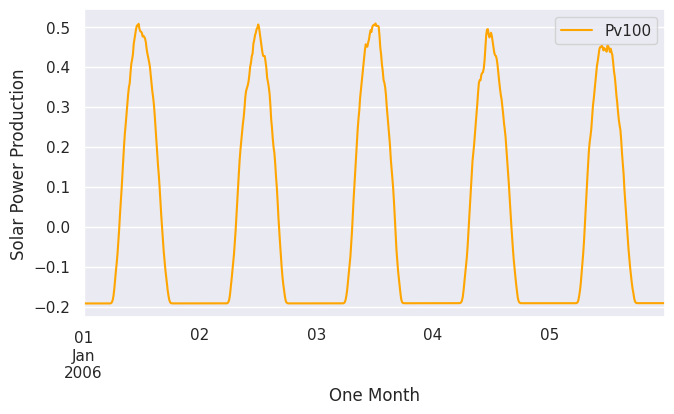

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})
seasonal.iloc[0:720].plot(y=['Pv100'] ,color=['orange'])

plt.ylabel('Solar Power Production')
plt.xlabel('One Month')

plt.show()

In [ ]:
# Split the data into train and test sets
train_seasonal,test_seasonal = seasonal[0:7884], seasonal[7884:]
train_seasonal, valid_seasonal = seasonal[0:7095], seasonal[7095:7884]

In [ ]:
X_trains, y_trains = split_series(train_seasonal.values,n_past, n_future)
X_trains = X_trains.reshape((X_trains.shape[0], X_trains.shape[1],n_features))
y_trains = y_trains.reshape((y_trains.shape[0], y_trains.shape[1], n_features))
X_tests, y_tests = split_series(test_seasonal.values,n_past, n_future)
X_tests = X_tests.reshape((X_tests.shape[0], X_tests.shape[1],n_features))
y_tests = y_tests.reshape((y_tests.shape[0], y_tests.shape[1], n_features))
X_valids, y_valids = split_series(valid_seasonal.values,n_past, n_future)
X_valids = X_valids.reshape((X_valids.shape[0], X_valids.shape[1],n_features))
y_valids = y_valids.reshape((y_valids.shape[0], y_valids.shape[1], n_features))

##St-LSTM Enc-Dec

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs = encoder(encoder_inputs)
encoder_states = encoder_outputs[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs[0])

decoder = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states)
decoder_outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder)

models = tf.keras.models.Model(encoder_inputs,decoder_outputs)

models.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 137)]    0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 100),        95200       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 3, 100)      0           ['lstm_1[0][0]']                 
                                                                                              

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
models.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error')
history=models.fit(X_trains,y_trains,epochs=30,validation_data=(X_valids,y_valids),batch_size=16,verbose=1,callbacks=[reduce_lr,es])

Epoch 1/30
442/442 [==============================] - 15s 23ms/step - loss: 0.0167 - val_loss: 0.0092 - lr: 0.0010
Epoch 2/30
442/442 [==============================] - 11s 24ms/step - loss: 0.0088 - val_loss: 0.0080 - lr: 0.0010
Epoch 3/30
442/442 [==============================] - 11s 24ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 0.0010
Epoch 4/30
442/442 [==============================] - 9s 20ms/step - loss: 0.0073 - val_loss: 0.0071 - lr: 0.0010
Epoch 5/30
442/442 [==============================] - 11s 24ms/step - loss: 0.0073 - val_loss: 0.0072 - lr: 0.0010
Epoch 6/30
442/442 [==============================] - 11s 25ms/step - loss: 0.0066 - val_loss: 0.0078 - lr: 0.0010
Epoch 7/30
442/442 [==============================] - 10s 22ms/step - loss: 0.0065 - val_loss: 0.0068 - lr: 0.0010
Epoch 8/30
442/442 [==============================] - 9s 21ms/step - loss: 0.0063 - val_loss: 0.0064 - lr: 0.0010
Epoch 9/30
442/442 [==============================] - 11s 25ms/step - loss: 0.0061

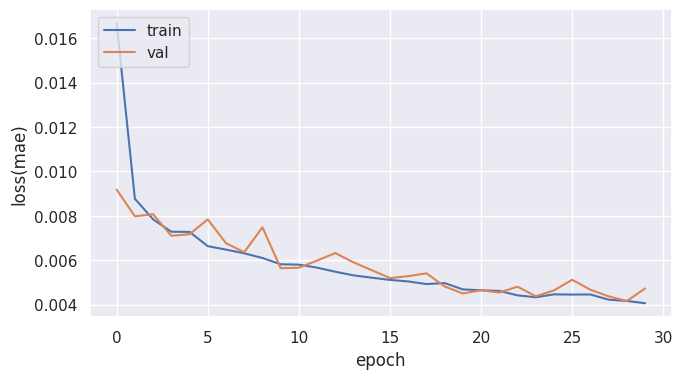

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss(mae)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
models.evaluate(X_tests,y_tests)

1396/1396 [==============================] - 19s 14ms/step - loss: 0.0045


0.004498809576034546

In [ ]:
preds = models.predict(X_tests)

1396/1396 [==============================] - 19s 13ms/step


In [ ]:
del(models)
del(X_tests)
del(X_trains)
del(X_valids)
del(y_tests)
del(y_trains)
del(y_valids)
del(seasonal)
gc.collect()

49611

##prediction Fusion

In [ ]:
pred = preds + predt + predr
print(pred.shape)

(44650, 3, 137)


In [ ]:
pred[<0]=0

In [ ]:
train,test = df[0:7884], df[7884:]
train, valid = df[0:7095], df[7095:7884]

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
print(X_test.shape)
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split_series(valid.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

(44650, 24, 137)


In [ ]:
mean_array = df.mean(axis = 0)
y_test_std = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
y_tst = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
for i in range(y_test.shape[0]):
  for j in range(n_future):
    y_test_std[i][j] = (y_test[i][j] - mean_array)* (y_test[i][j] - mean_array) #n x n_future x num_user

y_test_sum = y_test_std.mean(axis = 1) # n x num_user

##RSE & RSquare

In [ ]:
diff = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
diff = (y_test-pred)*(y_test-pred)
diff_sum = diff.mean(axis = 1)


diff_ = diff_sum.mean(axis = 1)
y_ = y_test_sum.mean(axis = 1)
diff__ = diff_.sum()
y__ = y_.sum()
rsquare = 1 - (diff__/y__)
rse = np.sqrt(diff__)/np.sqrt(y__)
print(rse)
print(rsquare)


0.2240246683479861
0.9498129479715749


In [ ]:
squared_diff_actual_pred = np.square(y_test - pred)

# Calculate squared differences between actual matrix and mean of actual matrix
mean_actual = np.mean(y_test)
squared_diff_actual_mean = np.square(y_test - mean_actual)

# Sum squared differences along all elements
sum_squared_diff_actual_pred = np.sum(squared_diff_actual_pred)
sum_squared_diff_actual_mean = np.sum(squared_diff_actual_mean)

# Calculate RSE
rse = np.sqrt(sum_squared_diff_actual_pred / sum_squared_diff_actual_mean)

print("Root Relative Squared Error (RSE):", rse)

Root Relative Squared Error (RSE): 0.22378096851607834


In [ ]:
actual_flat = y_test.flatten()
prediction_flat = pred.flatten()

# Calculate squared differences between actual and prediction values
squared_diff = np.square(actual_flat - prediction_flat)

# Calculate squared differences between actual values and mean of actual values
mean_actual = np.mean(actual_flat)
squared_diff_actual_mean = np.square(actual_flat - mean_actual)

# Sum squared differences along all elements
sum_squared_diff_actual_pred = np.sum(squared_diff)
sum_squared_diff_actual_mean = np.sum(squared_diff_actual_mean)

# Calculate RSE
rse = np.sqrt(sum_squared_diff_actual_pred / sum_squared_diff_actual_mean)

print("Root Relative Squared Error (RSE) with flattened matrices:", rse)

Root Relative Squared Error (RSE) with flattened matrices: 0.22378096851607834


In [ ]:
rmse = np.sqrt(np.mean((y_test - pred)**2))

# Calculate range of true values
denom=np.sqrt(np.mean((y_test - np.mean(y_test))**2))
rrse = rmse / denom
print("Root Relative Squared Error (RRSE):", rrse)

Root Relative Squared Error (RRSE): 0.22378096851607834


##CORR

#corr using function

In [ ]:
flat_matrix_1 =y_test.flatten()
flat_matrix_2 = pred.flatten()

# Calculate the correlation coefficient between the flattened arrays
correlation = np.corrcoef(flat_matrix_1, flat_matrix_2)[0, 1]

print("Correlation between the two 3D matrices:", correlation)

del(flat_matrix_1)
del(flat_matrix_2)
del(correlation)
gc.collect()

Correlation between the two 3D matrices: 0.9748861758792201


0

#corr according to lstnet

In [ ]:
y_true_mean= np.mean(y_test,axis=(1),keepdims=True)
# print(y_true_mean.shape)
y_pred_mean = np.mean(pred, axis=(1),keepdims=True)
# print(y_pred_mean.shape)

#for num
# print("num")
y_true_diff = y_test - y_true_mean
# print(y_true_diff.shape)

y_pred_diff = pred - y_pred_mean
# print(y_true_diff.shape)

sum_product_diff = y_true_diff * y_pred_diff
# print(sum_product_diff.shape)

num= np.sum(sum_product_diff,axis=1,keepdims=True)
# print(num.shape)

# print("")
# print("denom")
#for denom
y_true_diff_squared=y_true_diff**2
# print(y_true_diff_squared.shape)

y_pred_diff_squared =y_pred_diff**2
# print(y_true_diff_squared.shape)

sum_product_diff_squared = y_true_diff_squared * y_pred_diff_squared
# print(sum_product_diff_squared.shape)

denom_squared= np.sum(sum_product_diff_squared,axis=1,keepdims=True)
# print(denom_squared.shape)

denom=np.sqrt(denom_squared)
# print(denom.shape)
#division
# print("division")
eps = 1e-8
division= num/(denom+eps)
# print(division.shape)


print("corr")
corr_test=np.mean(division,axis=0)
# print(corr_test.shape)
# print(corr_test)
corr_final=np.mean(corr_test)

print(corr_final)

del(y_true_mean)
del(y_pred_mean)
del(y_true_diff_squared)
del(y_pred_diff_squared)
del(sum_product_diff_squared)
del(denom_squared)
del(denom)
del(division)
gc.collect()


corr
0.3880892453328378


0

In [ ]:
print(c)

NameError: ignored

##MAE

In [ ]:
dif = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
dif = np.abs(y_test-pred)
dif_sum = dif.mean(axis = 1)


dif_ = dif_sum.mean(axis = 1)
dif__ = dif_.sum()
print(dif__/y_test.shape[0])

0.03299959227539429


##SMAPE

In [ ]:
top = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
top = np.abs(y_test-pred)
bottom = (np.abs(y_test)+np.abs(pred))/2
val = top/bottom
val_ = val.mean(axis = 1)
val__ = val_.mean(axis = 1)
val___ = val__.sum()
smap = ((val___)/y_test.shape[0])
print(smap)

del(y_test_sum)
del(mean_array)
del(diff)
gc.collect()

1.2115087237688655


0

##Plot predict vs actual

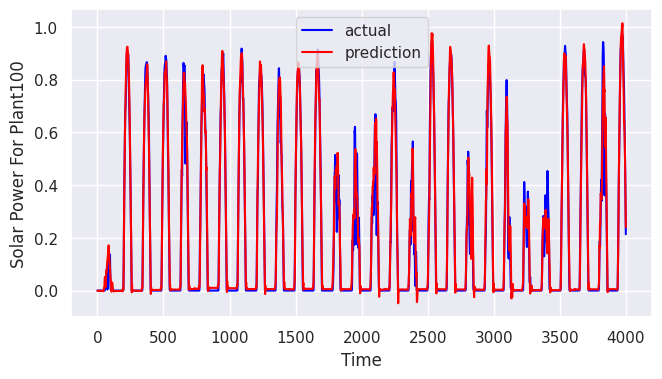

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})

meanpred = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
meanpred = pred.mean(axis=1)

b = pd.DataFrame(y_test.mean(axis=1))
b.columns = Header
b=b.iloc[0:4000][:]
plt.plot(b['Pv100'],label="actual",color='blue')

a = pd.DataFrame(meanpred)
a.columns = Header
a=a.iloc[0:4000][:]
plt.plot(a['Pv100'],label="prediction",color='red')


plt.ylabel('Solar Power For Plant100')
plt.xlabel('Time')
plt.legend()
#plt.show()

In [ ]:
del(diff_)
del(diff__)
del(diff_sum)
gc.collect()

30